In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import DirtyCorrectionMulDimSampler,VanillaSampler,ContinuousSampler,ContinuousApproxSampler, ContinuousApproxMulDimSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
import math
from rbmpy.rbm import weights_into_hiddens
from rbmpy.progress import Progress
from scipy.spatial.distance import cosine


import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

In [2]:
from IPython.core.debugger import Tracer

In [3]:
#load the data
import glob
result_file_name = glob.glob("Results/2615118/*")


raw_data = []
for result in result_file_name:
    with open(result,"rb") as f:
        raw_data.append(pickle.load(f))

other_file_name = glob.glob("Results/2613190/*")
other_raw_data = []
for result in other_file_name:
    with open(result,"rb") as f:
        other_raw_data.append(pickle.load(f))

# raw_data[0].keys()
# other_raw_data[0].keys()
for i in range(len(other_raw_data)):
    raw_data[i].update(other_raw_data[i])

In [5]:
def get_data(size):
    mnist_data = dict()
    for i in range(0,10):
        ds = np.load("datasets/{}.npy".format(i))[:size]
        try:
            with open("models/{}_models".format(i), 'rb') as f:
                model = pickle.load(f)
            mnist_data[i] = (model, ds)
        except FileNotFoundError:
            logging.warn("There is no model for {}".format(i))
    return mnist_data

# Structure of data

```{(n,m) => {'ORBM_RECONS':..,'RBM_RECONS':..., 'model_ids':(n,m),'DS_COMP':... }}```



In [83]:


class Result(object):
    
    def __init__(self):
        self.orbm_a_recons = {}
        self.orbm_b_recons = {}
        self.rbm_a_recons  = {}
        self.rbm_b_recons  = {}
        
        self.orbm_a_scores = {}
        self.orbm_b_scores = {}
        self.rbm_a_scores = {}
        self.rbm_b_scores = {}
        
    def safe_add(self, key, value, score_dict):
        if key not in score_dict:
            score_dict[key] = []
        score_dict[key].append(value)
    
#   orbm_a_recons, orbm_b_recons,rbm_a_recons, rbm_b_recons ,orbm_a_score, orbm_b_score, rbm_a_score, rbm_b_score
    def add_scores(self,model_ids, orbm_a_recons, orbm_b_recons, rbm_a_recons, rbm_b_recons,orbm_a, orbm_b, rbm_a,rbm_b):
        self.safe_add(model_ids, orbm_a_recons, self.orbm_a_recons)
        self.safe_add(model_ids, orbm_b_recons, self.orbm_b_recons)
        self.safe_add(model_ids, rbm_a_recons, self.rbm_a_recons)
        self.safe_add(model_ids, rbm_b_recons, self.rbm_b_recons)
        
        self.safe_add(model_ids, orbm_a, self.orbm_a_scores)
        self.safe_add(model_ids, orbm_b, self.orbm_b_scores)
    
        self.safe_add(model_ids, rbm_a, self.rbm_a_scores)
        self.safe_add(model_ids, rbm_b, self.rbm_b_scores)
    
    def hightest_scores(key, n):
        """Grab the n highest values from the key thing"""
        pass
    
    
    def ndarrayify(self, score_dict):
        nd_score_dict = {}
        for key in score_dict:
            nd_score_dict[key] = np.array(score_dict[key])
        return nd_score_dict

    def mean_scores(self):
        or_a = self.ndarrayify(self.orbm_a_scores)
        or_b = self.ndarrayify(self.orbm_b_scores)
        r_a  = self.ndarrayify(self.rbm_a_scores)
        r_b  = self.ndarrayify(self.rbm_b_scores)

        or_a = {k: v.mean(axis = 0) for k, v in or_a.items()}
        or_b = {k: v.mean(axis = 0) for k, v in or_b.items()}
        r_a  = {k: v.mean(axis = 0) for k, v in r_a.items()}
        r_b  = {k: v.mean(axis = 0) for k, v in r_b.items()}
        
        return or_a, or_b, r_a, r_b
    
    def matrix_for_scores(self,scores):
        x_idx, y_idx = list(map(list, zip(*scores.keys())))

        matrix = np.ones(shape=(max(x_idx)+1, max(y_idx)+1))
        for key in scores:
            matrix[key[0],key[1]] = scores[key].sum()

        return matrix
    
    def mean_score_matrices(self):
        or_a, or_b, r_a, r_b = self.mean_scores()
        
        return self.matrix_for_scores(or_a), self.matrix_for_scores(or_b), self.matrix_for_scores(r_a), self.matrix_for_scores(r_b)
    
def ll_image_wise_score(v, v_prime):

#     return -(abs(v - v_prime)).sum(1)
  
    return (v * np.log(v_prime) + ((1 - v) * np.log((1 - v_prime)))).sum(1)

def cosine_score(v, v_prime):
    thing = []
    for i in range(v.shape[0]):
        thing.append(1 - cosine(v[i,:],v_prime[i,:]))

        
    return np.array(thing)
    
def unzip_and_ndarrays(list_of_2d_tuple):
    a = list(map(list, zip(*list_of_2d_tuple)))
    return np.array(a[0]), np.array(a[1])
       
def scores_for_recons(target_recons,orbm_recons, rbm_recons):
    
    target_a_recons, target_b_recons = target_recons
    
    orbm_a_recons, orbm_b_recons = unzip_and_ndarrays(orbm_recons)
    rbm_a_recons, rbm_b_recons = unzip_and_ndarrays(rbm_recons)
    # Calculate the scores
    orbm_a_score = cosine_score(target_a_recons, orbm_a_recons)
    orbm_b_score = cosine_score(target_b_recons, orbm_b_recons)
    rbm_a_score = cosine_score(target_a_recons, rbm_a_recons)
    rbm_b_score = cosine_score(target_b_recons, rbm_b_recons)
    return orbm_a_recons, orbm_b_recons,rbm_a_recons, rbm_b_recons ,orbm_a_score, orbm_b_score, rbm_a_score, rbm_b_score

<img src = "Assets/LL_Score.png">

In [84]:
mnist_data = get_data(None)

In [85]:
def ds_from_mnist_ids(key, size):
    a_data = mnist_data[key[0]][1][:size]
    b_data = mnist_data[key[1]][1][:size]
    return rbmpy.datasets.flatten_data_set(a_data),rbmpy.datasets.flatten_data_set(b_data)

In [86]:
# # def scores_for_recons(target_recons,obrm_recons, rbm_recons, flattened_ds_comp)
# temp_orbm = raw_data[0][(1,1)]["ORBM_RECONS"] 
# temp_rbm = raw_data[0][(1,1)]["RBM_RECONS"]
# temp_ds_comp = raw_data[0][(1,1)]["DS_COMP"].reshape(temp_ds_comp.shape[0], temp_ds_comp.shape[1] * temp_ds_comp.shape[2])
# scores_for_recons((temp_ds_comp,temp_ds_comp),temp_orbm,temp_rbm, temp_ds_comp)[0].shape
# flattened_ds_comp = ds_comp.reshape(ds_comp.shape[0], ds_comp.shape[1] * ds_comp.shape[2])

In [87]:
result = Result()
for run in raw_data:
    for key in run:
# key = (2,1)
        current_comp = run[key]
        orbm_recons = current_comp["ORBM_RECONS"]
        rbm_recons = current_comp["RBM_RECONS"]

        size = current_comp["DS_COMP"].shape[0]
        target_recons = ds_from_mnist_ids(key, size)
        result.add_scores(key, *scores_for_recons(target_recons, orbm_recons,rbm_recons))

In [88]:
result.orbm_a_recons[(7,3)][0].shape

(500, 784)

In [89]:
a = result.mean_scores()
o_a, o_b, r_a, r_b = result.mean_score_matrices()

In [90]:
def plot_matrix(m, ticks):
    plt.imshow(m, interpolation='nearest',cmap=plt.cm.RdYlBu)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.colorbar()
    plt.show()

In [91]:
raw_data[0].keys()

dict_keys([(0, 1), (7, 3), (7, 1), (7, 6), (7, 4), (0, 6), (7, 5), (0, 5), (0, 4), (0, 3), (0, 8), (7, 8), (0, 2), (7, 2)])

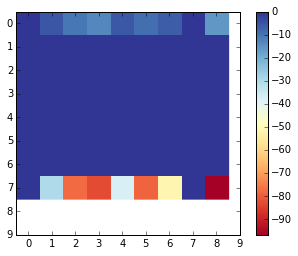

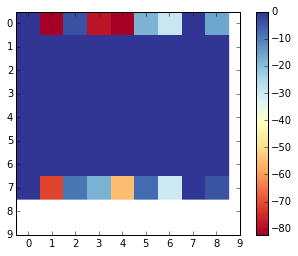

In [92]:
ticks = np.arange(10)
plot_matrix(o_a - r_a, ticks)
plot_matrix(o_b - r_b, ticks)

49 - np.where(np.isclose((o_b - r_b).T, (o_a - r_a)), 1,0).sum()


In [97]:
comp = (7,4)
or_score_of_interest = np.array(result.orbm_a_scores[comp])
or_recon_of_interest = np.array(result.orbm_a_recons[comp])

r_score_of_interest = np.array(result.rbm_a_scores[comp])
r_recon_of_interest = np.array(result.rbm_a_recons[comp])

or_max_idx = np.unravel_index(or_score_of_interest.argmax(), or_score_of_interest.shape)
# r_max_idx  = np.unravel_index(r_score_of_interest.argmax(), r_score_of_interest.shape)

# pp.image(or_recon_of_interest[or_max_idx[0], or_max_idx[1], :].reshape(28,28))
# pp.image(r_recon_of_interest[r_max_idx[0], or_max_idx[1], :].reshape(28,28))
# # pp.image(mnist_data[comp[0]][1][or_max_idx[1]])
# target = mnist_data[comp[0]][1][or_max_idx[1]]
# van_sampler = ContinuousSampler(mnist_data[comp[0]][0])
# pp.image(van_sampler.reconstruction_given_visible(target.reshape(28 * 28)).reshape(28, 28))

In [98]:
# or_score_of_interest[run].argsort()
or_score_of_interest[run][np.flipud(or_score_of_interest[run].argsort())]

array([ 0.96617776,  0.88821719,  0.88663218,  0.87350146,  0.87044068,
        0.86939833,  0.86051029,  0.85833585,  0.85815017,  0.85625728,
        0.85556122,  0.85440729,  0.85028962,  0.84824479,  0.84810299,
        0.84706865,  0.84460292,  0.84089053,  0.84089011,  0.84086637,
        0.83766881,  0.83702128,  0.83654114,  0.83570794,  0.83493949,
        0.83012064,  0.82838741,  0.82810074,  0.82688137,  0.82582579,
        0.82326479,  0.82292576,  0.82245459,  0.82236316,  0.82223617,
        0.82083444,  0.82039344,  0.81732892,  0.81419092,  0.81371044,
        0.81341374,  0.81238875,  0.81199152,  0.81187823,  0.81185397,
        0.80893468,  0.80792465,  0.80711652,  0.80540908,  0.8053103 ,
        0.80487152,  0.80379012,  0.80355089,  0.80337601,  0.80305399,
        0.80274546,  0.80174479,  0.80148867,  0.80069334,  0.79981073,
        0.79955431,  0.79944058,  0.79913529,  0.79740988,  0.79707132,
        0.79650052,  0.79546592,  0.79536987,  0.79491241,  0.79

orbm 0.9661777630645586
rbm 0.9661777630645586


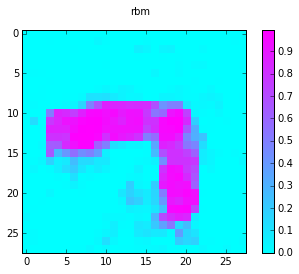

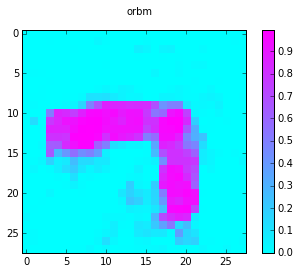

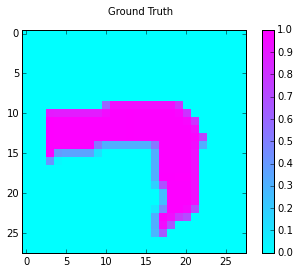

orbm 0.8882171936473237
rbm 0.8835830663532103


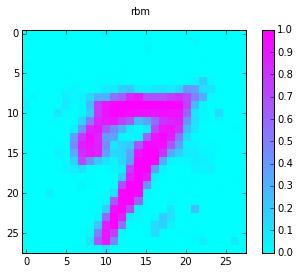

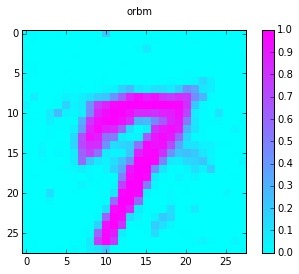

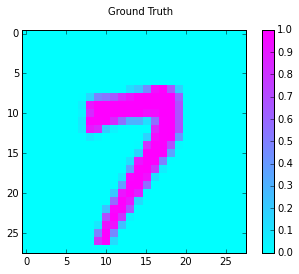

orbm 0.886632181010199
rbm 0.886632181010199


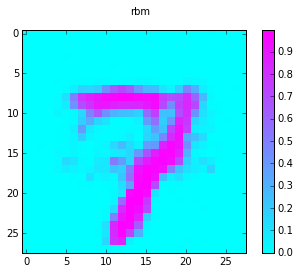

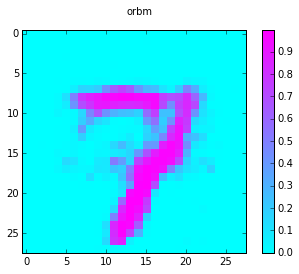

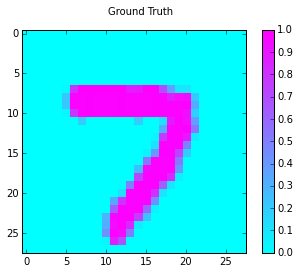

In [99]:
run = 0
range_length = 3
idx = np.flipud(or_score_of_interest[run].argsort())[:range_length]
idx
or_recon_of_interest[0].shape
for i in idx:
    print("orbm {}".format(or_score_of_interest[run][i]))
    print("rbm {}".format(r_score_of_interest[run][i]))
    plt.suptitle("rbm")
    pp.image(r_recon_of_interest[run,i].reshape(28,28))
    plt.suptitle("orbm")
    pp.image(or_recon_of_interest[run,i].reshape(28,28))
    plt.suptitle("Ground Truth")
    pp.image(mnist_data[comp[0]][1][i])

In [47]:
a = or_recon_of_interest[or_max_idx].reshape(28,28)
b = r_recon_of_interest[or_max_idx].reshape(28,28)
t = ds_from_mnist_ids(comp,size=200)[0][or_max_idx[1]].reshape(28,28)

IndexError: index 441 is out of bounds for axis 0 with size 200

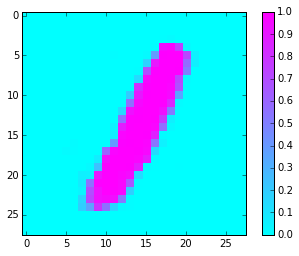

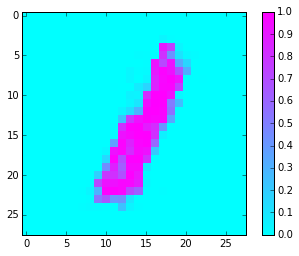

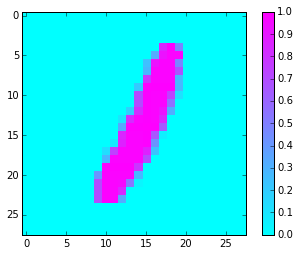

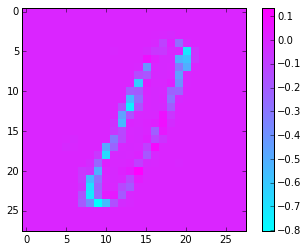

20.9823548305
22.4297747339


-20.982354830500149

In [21]:
pp.image(a)
pp.image(b)
pp.image(t)
pp.image(t-a)
print(abs(t - a).sum())
print(abs(t - b).sum())
or_score_of_interest[or_max_idx]

In [22]:
or_score_of_interest.max()


-20.982354830500149

In [23]:
or_max_idx

(14, 45)

In [24]:
print("orbm{}".format(np.array(result.orbm_a_scores[(1,2)]).mean(0).max()))
print("rbm{}".format(np.array(result.rbm_a_scores[(1,2)]).mean(0).max()))

orbm-10.889619720289089
rbm-29.76803166138369


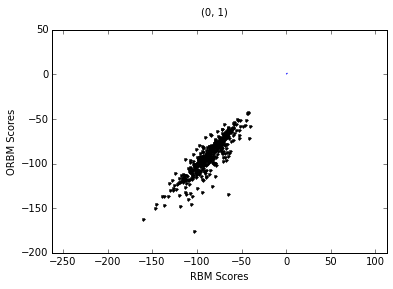

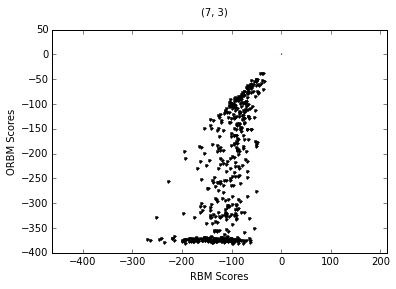

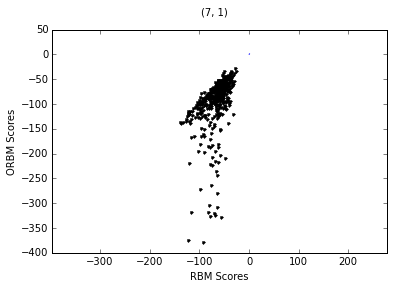

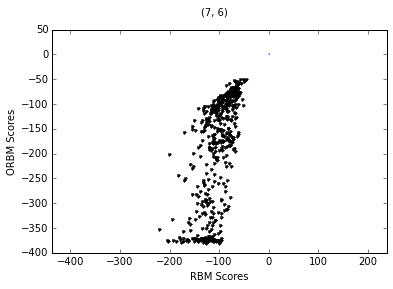

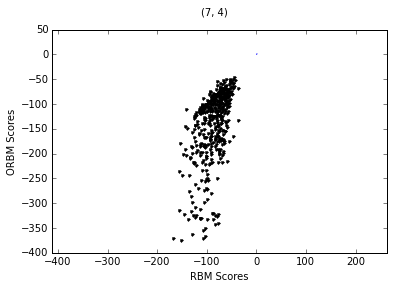

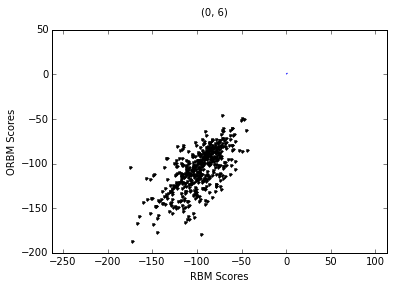

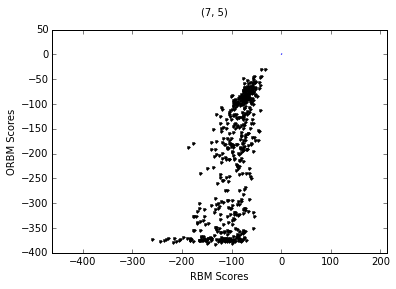

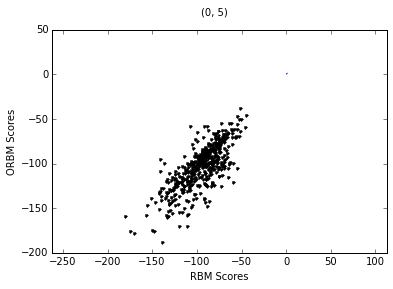

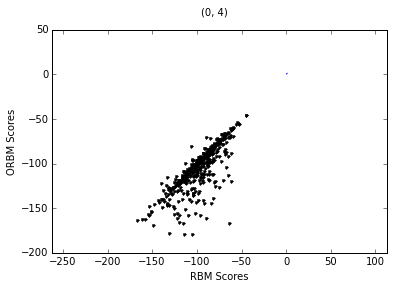

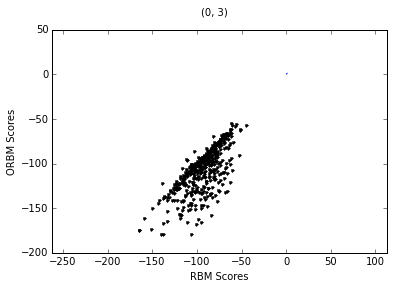

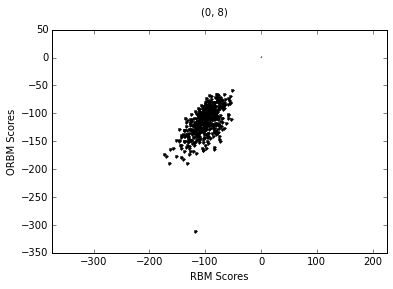

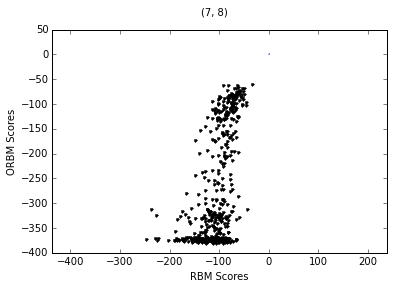

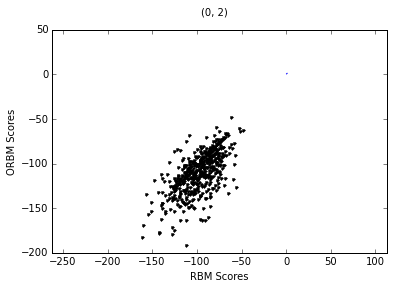

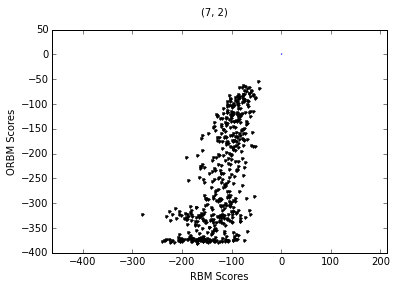

In [48]:
key = (1,7)
for key in result.rbm_a_scores.keys():
    plt.suptitle("{}".format(key))
    plt.plot(np.array(result.rbm_a_scores[key]).mean(0), np.array(result.orbm_a_scores[key]).mean(0),'.k')
#     plt.scatter(np.array(result.rbm_a_scores[key]).mean(0), np.array(result.orbm_a_scores[key]).mean(0),s=20,cmap=plt.cm.Greys)
    plt.plot([0.4,1],[0.4,1])
    plt.axis('equal')
    plt.ylabel("ORBM Scores")
    plt.xlabel("RBM Scores")
    plt.show()


In [37]:
mnist_data[2][0].visible_bias.max()

-2.9503494467702178